---
title: 'Lab02: Portugese Bank Marketing Data'
subtitle: "MSDS 7331"
authors: "Anthony Burton-Cordova, Will Jones, Nick Sager"
date: October 16, 2023
jupyter: python3
---

## Introduction

For an introduction to the data, business understanding, and explanation of the the dataset, please see [Lab01](Lab01.ipynb), which contains the exploratory data analysis (EDA) from Lab 01. This notebook will focus on building classification models of the data.

## Import and Process Data

The following code chunks are explained in more detail in [Lab01](Lab01.ipynb).

In [1]:
import pandas as pd

# Choose File
RawBank = "https://raw.githubusercontent.com/NickSager/DS7331_Projects/main/data/bank-additional-full.csv"
# RawBank = "data/bank-additional-full.csv"

# Read the CSV file with a semicolon ; separator
bank = pd.read_csv(RawBank, sep=';')

# Get info on the dataset
# print(bank.info())
# bank.describe()

In [2]:
import numpy as np

# let's set those values to NaN, so that Pandas understand they are missing
df = bank.copy() # make a copy of the dataframe
df = df.replace(to_replace = 'unknown', value = np.nan) # replace unknown with NaN (not a number)
df = df.replace(to_replace = 999, value = np.nan) # replace 999 with NaN (not a number)
df = df.replace(to_replace = 'nonexistent', value = np.nan) # replace nonexistent with NaN (not a number)

# print (df.info())
# df.describe() # scroll over to see the values

# From course material "01. Pandas.ibynb"

In [3]:
# Change NA Categoricals to 'unknown'
df['job'] = df['job'].fillna('unknown')
df['marital'] = df['marital'].fillna('unknown')
df['education'] = df['education'].fillna('unknown')

# Change NA Credit history values to 'no'
df['default'] = df['default'].fillna('no')
df['housing'] = df['housing'].fillna('no')
df['loan'] = df['loan'].fillna('no')

# Change NA Previous Outcome to 'not contacted'
df['poutcome'] = df['poutcome'].fillna('not contacted')

# Change NA pdays to the mean
df['pdays'] = df['pdays'].fillna(df['pdays'].mean())

# Change NA Duration to '999'
df['duration'] = df['duration'].fillna(999)

# let's break up the age variable
df['age_range'] = pd.cut(df.age,[0,40,60,1e6],3,labels=['Young','Middle-Age','Old']) # this creates a new variable
# df.age_range.describe()

# print(df.info())

## Data Preparation Part 1

Our class variable or response variable, labeled 'y' in the dataset, is a binary object denoting whether the client has subscribed to a term deposit. It takes on two values, 'y' (indicating 'yes') and 'n' (indicating 'no').

The dataset and processing is explained in more detail in [Lab01](Lab01.ipynb).

Scaling and dimensionality reduction will be handled in a SKL `pipeline` object in the model creation section below.

In [4]:
# Convert all categorical features to numeric using dummy variables
df = pd.get_dummies(df, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'age_range'], drop_first=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   duration                       41188 non-null  float64
 2   campaign                       41188 non-null  int64  
 3   pdays                          41188 non-null  float64
 4   previous                       41188 non-null  int64  
 5   emp.var.rate                   41188 non-null  float64
 6   cons.price.idx                 41188 non-null  float64
 7   cons.conf.idx                  41188 non-null  float64
 8   euribor3m                      41188 non-null  float64
 9   nr.employed                    41188 non-null  float64
 10  y                              41188 non-null  object 
 11  job_blue-collar                41188 non-null  uint8  
 12  job_entrepreneur               41188 non-null 

The following code chunk generates an Exploratory Data Analysis widget that can be used to check the quality of our processed dataset. It takes a while to run and can be re-rendered by commenting out the triple quotes.

In [19]:
'''

# You can run this if you want to view the YData Profile Report (EDA Report) for the expanded data.
import pandas as pd
from ydata_profiling import ProfileReport

#Run the Profile Report
profile = ProfileReport(
    df, title="df1.html", explorative=True
    )

#Send the code to the HTML File or notebook
# profile.to_file("df1.html")
profile.to_widgets()
# profile.to_notebook_iframe()

'''

'\n\n# You can run this if you want to view the YData Profile Report (EDA Report) for the expanded data.\nimport pandas as pd\nfrom ydata_profiling import ProfileReport\n\n#Run the Profile Report\nprofile = ProfileReport(\n    df, title="df1.html", explorative=True\n    )\n\n#Send the code to the HTML File or notebook\n# profile.to_file("df1.html")\nprofile.to_widgets()\n# profile.to_notebook_iframe()\n\n'

## Data Preparation Part 2

Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

The final dataset is made up of 53 variables. As seen below, the data types are : float64(7), int64(4), object(1), uint8(42)

We changed the initial variables of Job, Marital Status, Education, Default, Housing, Loan, Month, Day of Week, Poutcome, and Age Range into distinct levels using methods seen in [Lab01](Lab01.ipynb).

In [20]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   duration                       41188 non-null  float64
 2   campaign                       41188 non-null  int64  
 3   pdays                          41188 non-null  float64
 4   previous                       41188 non-null  int64  
 5   emp.var.rate                   41188 non-null  float64
 6   cons.price.idx                 41188 non-null  float64
 7   cons.conf.idx                  41188 non-null  float64
 8   euribor3m                      41188 non-null  float64
 9   nr.employed                    41188 non-null  float64
 10  y                              41188 non-null  object 
 11  job_blue-collar                41188 non-null  uint8  
 12  job_entrepreneur               41188 non-null 

## Modeling and Evaluation 1

The first task we will perform is classification of records into whether or not the customer subscribes to a term deposit. As in the previous lab, we will not include `duration` for this task. The second task will be to predict the duration of the call by regression. We will use the same features as the previous task, while leaving out whether the customer subscribed or not.

**Task One:** Classification

ROC - AUC will be used to evaluate the models fro task one.

Due to previous work in Lab01.ipynb it was shown that our response variable, whether a customer will subscribe to a term deposit, was highly unbalanced with only 11% of the variable data being 'yes' so for the metric we will choose ROC-AUC. The common metric accuracy would not be good for this model due to it only being able to assess the correct number of true predictions in the samples from the dataset but fails to take into account the false positives. 

The Area Under the Curve is great for classification models and takes into account the relationship between the true positive rate and the false positive rate. It's value is contained in the range of 0.5 and 1 being that if the models auc is 0.5 it predicts no better than a flip of a coin at random or 1 being that it is the perfect classifier. In our case, the accuracy of a model that only guesses the majority class would approach 90%, but the true positive rate would be 0%. The ROC-AUC allows us to evaluate how the model performs on both the minority and majority classes.

Because we are primarily concerned with the minority class, we could also use the F1 score, balanced accuracy, precision-recall curve, or the Matthews correlation coefficient (MCC). We have chosen the ROC-AUC because it is easy to interpret and the others were not covered in the course.

**Task Two:** Regression

For task two we will be using the Mean Absolute Error (MAE), R2, and Explained Variance to evaluate performance. We have chosen MAE because it is a common metric for regression models that will be familiar to readers. The MAE is also easy to interpret because it is in the same units as the response variable. We chose R2 to measure the goodness of a fit for the regression model as well as ease of understanding. Last, we 

## Modeling and Evaluation 2

First, we will change the data into a format that Scikit-Learn can use. We will also split the data into training and validation sets for each task.

The code in this section is adopted from the course material in the notebook '04. Logits and SVM.ipynb'.

**Task One:**

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

# Copy dataframe for each task
df1 = df.copy()

# Consider deleting duration for practicality
if 'duration' in df1: del df1['duration']

# we want to predict the X and y data as follows:
X1 = df1.drop(columns=['y']).values
y1 = df1['y'].values
    
# Split into training and test sets
X1_train_holdout, X1_test_holdout, y1_train_holdout, y1_test_holdout = train_test_split(
    X1, y1, test_size=0.2, random_state=137, stratify=y1)


**Task Two:**

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

# Copy dataframe for each task
df2 = df.copy()

# Consider deleting duration for practicality
if 'y' in df2: del df2['y']

# we want to predict the X and y data as follows:
X2 = df2.drop(columns=['duration']).values
y2 = df2['duration'].values
    
# Split into training and test sets
X2_train_holdout, X2_test_holdout, y2_train_holdout, y2_test_holdout = train_test_split(
    X2, y2, test_size=0.2, random_state=137)

The 'holdout' splits will be used to evaluate the final model on unseen data. We will additionally use cross-validation to tune the hyperparameters of the models.

Next we will define the parts of the pipeline that will be used to transform the data and fit the models. We will use a StandardScaler to scale the data, and experiment with using PCA to reduce the dimensionality of the data.

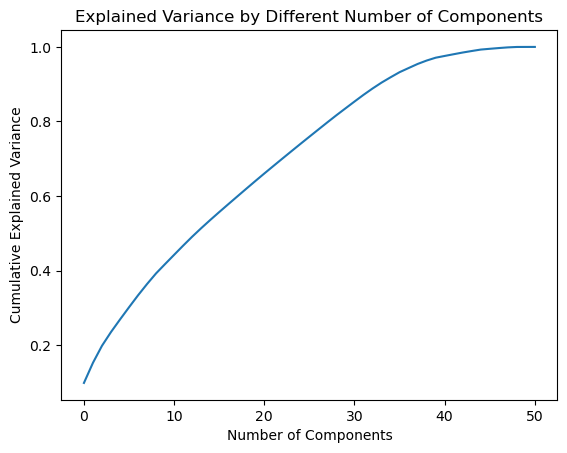

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# First, scale the data with StandardScaler
scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train_holdout)  

# Fit PCA on the scaled data
pca = PCA()
pca.fit(X1_train_scaled)  # PCA is only fitted on the features

cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Generate the plot
plt.figure()
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Different Number of Components')
plt.show()


Principal component analysis requires most of the features to explain the majority of the variance in the data. We will not use PCA in our pipeline.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit

# Resampling related libraries
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imblearnPipeline

resample = SMOTE()

# Define the model as a placeholder to use in the pipeline
model = LogisticRegression(penalty='l2',
                           C=1.0,
                           class_weight=None,
                           solver='liblinear',
                           random_state=137,
                           max_iter=150)

# Define the pipeline
pipe = imblearnPipeline([
    ('resample', resample),
    ('scaler', StandardScaler()),
    ('classifier', model)
])
# Use pipe.set_params(classifier=model) to change the model

# Define the cross validation method on training holdout
cv1 = StratifiedKFold(n_splits=5, random_state=137, shuffle=True)
cv2 = ShuffleSplit(n_splits=5, random_state=137)

**Task One:**

We have chosen to use a stratified 5-fold cross validation to evaluate our models. Stratified is necessary because it preserves the proportion of samples of each class in each fold. Because the dataset is so imbalanced, non-stratified cross validation could result in some folds having no samples of the minority class, which would make the models impossible to evaluate or give misleading results.

We have chosen 5-folds because of the balance between bias and computational efficiency. Larger folds (smaller evaluation sets) more closely approximate the training data in size and thus will have lower bias. However, with our unbalanced dataset, this could cause representation problems with the minority class. This configuration is also more computationally demanding. Five folds is considered to be a good balance between these two factors.

Additionally, we will used the Imbalanced Learn Pipeline module to implement minority class oversampling within the cross validation loop. This will help to address the class imbalance problem. This module doesn't allow the oversampled synthetic data to leak into the validation phase because the resampling only occurs within the training portion of each fold during the cross-validation process. Synthetic Minority-class Oversampling Technique (SMOTE) is chosen because it is a popular and effective oversampling method.

**Task Two:**

For Task Two: much of the above remain true, however for regression we went with the ShuffleSplit method which involves randomly shuffling the data and splitting it into training and testing sets multiple times. We also went with 5-fold due to the explanation above.

## Modeling and Evaluation 3


Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!

### Task One: Classification:

The first classifier we will fit is the Logistic Regression:

In [25]:
# Simple method which doesn't give Confusion Matrix
from sklearn.model_selection import cross_val_score

model = LogisticRegression(penalty='l2',
                           C=1.0,
                           class_weight=None,
                           solver='liblinear',
                           random_state=137,
                           max_iter=150)

pipe.set_params(classifier=model)
 
rocauc_lr = cross_val_score(estimator = pipe,
                                X=X1_train_holdout,
                                y=y1_train_holdout,
                                cv=cv1,
                                scoring="roc_auc",
                                n_jobs=-1)
print(rocauc_lr)

# Calculate mean and std deviation of the accuracies
mean_ra_lr2 = np.mean(rocauc_lr)
std_ra_lr2 = np.std(rocauc_lr)

print(f"\nOverall ROC-AUC: {mean_ra_lr2:.4f} (+/- {std_ra_lr2:.4f})")

[0.80327529 0.78403967 0.78212769 0.79073726 0.80367438]

Overall ROC-AUC: 0.7928 (+/- 0.0092)


In [26]:
# More Complicated method with more diagnostics
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import numpy as np

model = LogisticRegression(penalty='l2',
                           C=1.0,
                           class_weight=None,
                           solver='liblinear',
                           random_state=137,
                           max_iter=150)

pipe.set_params(classifier=model)

# Get the decision function scores or probabilities for each instance using cross-validation.
y_scores = cross_val_predict(estimator=pipe,
                             X=X1_train_holdout,
                             y=y1_train_holdout,
                             cv=cv1,
                             method='decision_function',  # or 'predict_proba'
                             n_jobs=-1)

# y_scores = y_scores[:, 1] # Only for predict_proba

# Calculate the overall ROC-AUC
lr_overall_rocauc = roc_auc_score(y1_train_holdout, y_scores)

# Calculate AUC per fold
lr_auc_scores = []
for train_idx, test_idx in cv1.split(X1_train_holdout, y1_train_holdout):
    fold_proba = pipe.fit(X1_train_holdout[train_idx], y1_train_holdout[train_idx]).decision_function(X1_train_holdout[test_idx])
    fold_auc = roc_auc_score(y1_train_holdout[test_idx], fold_proba)
    lr_auc_scores.append(fold_auc)

auc_std = np.std(lr_auc_scores)

# Predict Classes for CM
y_pred = np.where(y_scores > 0.5, 'yes', 'no')  # 0.5 for LR, 0 for Decision Boundaries

lr_conf_matrix = confusion_matrix(y_true=y1_train_holdout, y_pred=y_pred)
lr_class_report = classification_report(y_true=y1_train_holdout, y_pred=y_pred)


# Display the results
print(f"Overall ROC-AUC: {lr_overall_rocauc:.4f}")
print(f"Standard Deviation of the AUC scores: {auc_std:.4f}")
print(f"Confusion Matrix: \n{lr_conf_matrix}")
print(f"Classification Report: \n{lr_class_report}")

Overall ROC-AUC: 0.7921
Standard Deviation of the AUC scores: 0.0095
Confusion Matrix: 
[[26080  3158]
 [ 1539  2173]]
Classification Report: 
              precision    recall  f1-score   support

          no       0.94      0.89      0.92     29238
         yes       0.40      0.59      0.48      3712

    accuracy                           0.86     32950
   macro avg       0.67      0.74      0.70     32950
weighted avg       0.88      0.86      0.87     32950



The Logistic Regression model has an overall ROC-AUC or 0.79 on the training set. It struggles to correctly classify the minority class and has a Recall of 0.59.

In [27]:
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd

model = LogisticRegression(penalty='l2',
                           C=1.0,
                           class_weight=None,
                           solver='liblinear',
                           random_state=137,
                           max_iter=150)

pipe.set_params(classifier=model)

param_grid_logistic = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_search = GridSearchCV(pipe, param_grid_logistic,
                        cv=cv1, n_jobs=-1, error_score=np.nan,
                        scoring='roc_auc')
grid_search.fit(X1_train_holdout, y1_train_holdout)

lr_best_model = grid_search.best_estimator_

print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score (ROC-AUC): ", grid_search.best_score_)

results = pd.DataFrame(grid_search.cv_results_)
results = results[['mean_test_score', 'std_test_score', 'params']]
sorted_results = results.sort_values(by='mean_test_score', ascending=False)
sorted_results.head(10)


C:\Users\Willj\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
240 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Willj\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Willj\anaconda3\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "C:\Users\Willj\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penal

Best parameters:  {'classifier__C': 0.01, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best cross-validation score (ROC-AUC):  0.7938515839611697


,mean_test_score,std_test_score,params
17,0.793852,0.010541,"{'classifier__C': 0.01, 'classifier__penalty':..."
68,0.793496,0.008603,"{'classifier__C': 10, 'classifier__penalty': '..."
83,0.793381,0.008862,"{'classifier__C': 100, 'classifier__penalty': ..."
19,0.793224,0.010915,"{'classifier__C': 0.01, 'classifier__penalty':..."
80,0.793191,0.008794,"{'classifier__C': 100, 'classifier__penalty': ..."
67,0.793186,0.008669,"{'classifier__C': 10, 'classifier__penalty': '..."
66,0.793149,0.008871,"{'classifier__C': 10, 'classifier__penalty': '..."
53,0.793106,0.008591,"{'classifier__C': 1, 'classifier__penalty': 'l..."
32,0.792954,0.009508,"{'classifier__C': 0.1, 'classifier__penalty': ..."
51,0.792878,0.008718,"{'classifier__C': 1, 'classifier__penalty': 'l..."


A grid search across the possible parameters for Logistic Regression does not yield much improvement. This indicates that the default parameters for LR are close to optimal, so we will use those.

The next classification model we will use is a Random Forest Classifier:

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd

# Create a new Random Forest classifier
model = RandomForestClassifier(random_state=137)

pipe.set_params(classifier=model)

# Define Random Forest specific parameters for the grid search
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__max_depth': [10, 50, None],
    'classifier__min_samples_split': [2, 4, 6],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

grid_search = GridSearchCV(pipe, param_grid_rf,
                        cv=cv1, n_jobs=-1, error_score=np.nan,
                        scoring='roc_auc')
grid_search.fit(X1_train_holdout, y1_train_holdout)

# Get the best estimator and update pipe
rf_best_model = grid_search.best_estimator_
pipe.set_params(classifier=rf_best_model)

# Now, you can directly predict using the best model
y_pred = rf_best_model.predict(X1_train_holdout)
# y_scores = best_model.decision_function(X1_train_holdout)  # for models with decision_function
y_scores = rf_best_model.predict_proba(X1_train_holdout)[:, 1] # for models providing probabilities

# Calculate the overall ROC-AUC
rf_overall_rocauc = roc_auc_score(y1_train_holdout, y_scores)

# Calculate AUC per fold
# Recomputes one pass, but useful for variance
rf_auc_scores = []
for train_idx, test_idx in cv1.split(X1_train_holdout, y1_train_holdout):
    pipe.fit(X1_train_holdout[train_idx], y1_train_holdout[train_idx])
    # fold_proba = pipe.decision_function(X1_train_holdout[test_idx]) # models with decision function
    fold_proba = pipe.predict_proba(X1_train_holdout[test_idx])[:, 1] # for models providing probabilities
    fold_auc = roc_auc_score(y1_train_holdout[test_idx], fold_proba)
    rf_auc_scores.append(fold_auc)

auc_std = np.std(rf_auc_scores)
# Constructing the confusion matrix
rf_conf_matrix = confusion_matrix(y_true=y1_train_holdout, y_pred=y_pred)

# Getting detailed classification report
rf_class_report = classification_report(y_true=y1_train_holdout, y_pred=y_pred)

# Displaying grid search results in a pandas DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)
# Filter necessary columns
results_df = results_df[['param_classifier__n_estimators', 'param_classifier__max_features',
                         'param_classifier__max_depth', 'param_classifier__min_samples_split',
                         'param_classifier__min_samples_leaf', 'param_classifier__bootstrap',
                         'mean_test_score', 'std_test_score', 'rank_test_score']]
# Set option to display all columns of DataFrame
pd.set_option('display.max_columns', None)
print(results_df.sort_values('rank_test_score'))

# Displaying the results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score (ROC-AUC): {grid_search.best_score_:.4f}")
print(f"Overall ROC-AUC on the training set: {rf_overall_rocauc:.4f}")
print(f"Confusion Matrix: \n{rf_conf_matrix}")
print(f"Classification Report: \n{rf_class_report}")

/opt/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


    param_classifier__n_estimators param_classifier__max_features  \
263                            200                           log2   
161                            200                           log2   
107                            200                           log2   
101                            200                           log2   
158                            200                           log2   
..                             ...                            ...   
299                            200                           log2   
270                             50                           sqrt   
216                             50                           sqrt   
297                             50                           log2   
243                             50                           log2   

    param_classifier__max_depth param_classifier__min_samples_split  \
263                          50                                   2   
161                        No

The Random Forest model achieves an overall ROC-AUC on the training set of 0.94. It has a Recall of 0.56 for the 'yes' class, which is comparable to the other models, but with a higher precision of 0.74.

Interestingly, the best performing combinations of parameters are quite similar. They use a maximum depth of 50, maximum features of 'log2', and use bootstrapping. There is a mix of 100 and 200 estimators among the top 5.

Next, we will fit a K-Nearest Neighbors Model.

KNN:

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd

# Create a new K-Nearest Neighbors classifier
model = KNeighborsClassifier()

pipe.set_params(classifier=model)

# Define KNN specific parameters for the grid search
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 10, 30, 100, 500],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'classifier__p': [1, 2]  # Manhatten Distance and Euclidean Distance
}

grid_search = GridSearchCV(pipe, param_grid_knn,
                        cv=cv1, n_jobs=-1, error_score=np.nan,
                        scoring='roc_auc')
grid_search.fit(X1_train_holdout, y1_train_holdout)

# Get the best estimator and update pipe
knn_best_model = grid_search.best_estimator_
pipe.set_params(classifier=knn_best_model)

# Now, you can directly predict using the best model
y_pred = knn_best_model.predict(X1_train_holdout)
# y_scores = best_model.decision_function(X1_train_holdout)  # for models with decision_function
y_scores = knn_best_model.predict_proba(X1_train_holdout)[:, 1] # for models providing probabilities

# Calculate the overall ROC-AUC
knn_overall_rocauc = roc_auc_score(y1_train_holdout, y_scores)

# Calculate AUC per fold
# Probably not efficient because it recomputes for best model
knn_auc_scores = []
for train_idx, test_idx in cv1.split(X1_train_holdout, y1_train_holdout):
    pipe.fit(X1_train_holdout[train_idx], y1_train_holdout[train_idx])
    # fold_proba = pipe.decision_function(X1_train_holdout[test_idx]) # models with decision function
    fold_proba = pipe.predict_proba(X1_train_holdout[test_idx])[:, 1] # for models providing probabilities
    fold_auc = roc_auc_score(y1_train_holdout[test_idx], fold_proba)
    knn_auc_scores.append(fold_auc)

auc_std = np.std(knn_auc_scores)
# Constructing the confusion matrix
knn_conf_matrix = confusion_matrix(y_true=y1_train_holdout, y_pred=y_pred)

# Getting detailed classification report
knn_class_report = classification_report(y_true=y1_train_holdout, y_pred=y_pred)

# Displaying grid search results in a pandas DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)
# Filter necessary columns
results_df = results_df[['param_classifier__n_neighbors', 'param_classifier__weights',
                         'param_classifier__algorithm', 'param_classifier__p',
                         'mean_test_score', 'std_test_score', 'rank_test_score']]
# Set option to display all columns of DataFrame
pd.set_option('display.max_columns', None)
print(results_df.sort_values('rank_test_score'))

# Displaying the results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score (ROC-AUC): {grid_search.best_score_:.4f}")
print(f"Overall ROC-AUC on the training set: {knn_overall_rocauc:.4f}")
print(f"Confusion Matrix: \n{knn_conf_matrix}")
print(f"Classification Report: \n{knn_class_report}")

   param_classifier__n_neighbors param_classifier__weights  \
44                           500                   uniform   
68                           500                   uniform   
20                           500                   uniform   
92                           500                   uniform   
70                           500                   uniform   
..                           ...                       ...   
24                             3                   uniform   
73                             3                  distance   
49                             3                  distance   
25                             3                  distance   
1                              3                  distance   

   param_classifier__algorithm param_classifier__p  mean_test_score  \
44                   ball_tree                   1         0.787581   
68                     kd_tree                   1         0.787163   
20                        auto            

The KNN achieves an overall ROC-AUC of 0.80 on the training set. It has a Recall of 0.58 for the 'yes' class, which is comparable to the other models. The precision is low at 0.40. 

The best performing KNN models use uniform weights and Manhattan distance. There is a mix of algorithms, but the top performing models all use the largest amount of neighbors.

**Task Two: Regression using the Extra Trees Regressor, Random Forest Regressor, and Lasso Regression**

*Extra Trees Regression*

In [14]:
#Create a Linear Regression object and perform a grid search to find the best parameters
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

linreg = ExtraTreesRegressor()

parameters = {}
# parameters = { 'classifier__min_samples_split':[2]#,3,4,5]
#               ,'classifier__n_estimators' : [50]#, 100, 500]
#               ,'classifier__min_samples_leaf': [10]#, 25, 50]
#               ,'classifier__criterion': ['absolute_error']
#               ,'classifier__random_state': [0]
#              }

pipe.set_params(classifier=linreg)
pipe.set_params(resample=None)

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
'''regGridSearch = GridSearchCV(estimator=pipe
                   , n_jobs=-1 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=1) 
                   , scoring=mae_scorer
                   , error_score='raise')'''

# Define the scoring metrics as a list
scoring = ['neg_mean_absolute_error', 'r2']

xt_grid_search = GridSearchCV(pipe, parameters,
                        cv=cv2, n_jobs=-1, error_score=np.nan,return_train_score=True,
                        scoring=scoring, refit="r2")

xt_grid_search.fit(X2_train_holdout, y2_train_holdout)


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=137, test_size=None, train_size=None),
             estimator=Pipeline(steps=[('resample', None),
                                       ('scaler', StandardScaler()),
                                       ('classifier', ExtraTreesRegressor())]),
             n_jobs=-1, param_grid={}, refit='r2', return_train_score=True,
             scoring=['neg_mean_absolute_error', 'r2', 'explained_variance'])

In [25]:
# Get the best estimator and update pipe
xt_best_model = xt_grid_search.best_estimator_
pipe.set_params(classifier=xt_best_model)

# Displaying the results
print(f"Best parameters: {xt_grid_search.best_params_}")
print(f"\nBest cross-validation score (MAE): {xt_grid_search.best_score_:.4f}")

# Displaying the results
print(f"\nOverall MAE:" + str(xt_grid_search.cv_results_['mean_train_neg_mean_absolute_error']) + "(+/-" + str(xt_grid_search.cv_results_['std_train_neg_mean_absolute_error'])+")")

print(f"\nOverall R2: " + str(xt_grid_search.cv_results_['mean_train_r2']) + " (+/-"+ str(xt_grid_search.cv_results_['std_train_r2']) + ")")


Best parameters: {}

Best cross-validation score (MAE): -0.3423

Overall MAE:[-9.22569988](+/-[0.12157402])

Overall R2: [0.96461539] (+/-[0.00152488])

Overall explained_variance: [0.96461539] (+/-[0.00152488])


*Lasso Regression*

In [26]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score


reg = Lasso(fit_intercept=True, copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001]#, 0.1, 1, 10, 20]
selection = ['cyclic']#,'random']
warm_start = [True, False]
parameters = {'classifier__alpha': alpha, 'classifier__selection': selection, 'classifier__warm_start': warm_start}

pipe.set_params(classifier=reg)
pipe.set_params(resample=None)

# Define the scoring metrics as a list
scoring = ['neg_mean_absolute_error', 'r2']

#Create a grid search object using the parameters above
lr_grid = GridSearchCV(pipe, parameters,
                        cv=cv2, n_jobs=-1, error_score=np.nan,
                        scoring=scoring, refit='neg_mean_absolute_error', return_train_score=True,)

lr_grid.fit(X2_train_holdout, y2_train_holdout)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=137, test_size=None, train_size=None),
             estimator=Pipeline(steps=[('resample', None),
                                       ('scaler', StandardScaler()),
                                       ('classifier',
                                        Lasso(max_iter=10000, precompute=True,
                                              random_state=0))]),
             n_jobs=-1,
             param_grid={'classifier__alpha': [0.001],
                         'classifier__selection': ['cyclic'],
                         'classifier__warm_start': [True, False]},
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring=['neg_mean_absolute_error', 'r2', 'explained_variance'])

In [37]:

# Get the best estimator and update pipe
lasso_best_model = lr_grid.best_estimator_
pipe.set_params(classifier=lasso_best_model)

# Displaying the results
print(f"\nBest parameters: {lr_grid.best_params_}")


# Displaying the results
print(f"\nOverall MAE:" + str(lr_grid.cv_results_['mean_train_neg_mean_absolute_error'][0]) + "(+/-" + str(lr_grid.cv_results_['std_train_neg_mean_absolute_error'][0])+")")

print(f"\nOverall R2: " + str(lr_grid.cv_results_['mean_train_r2'][0]) + " (+/-"+ str(lr_grid.cv_results_['std_train_r2'][0]) + ")")



Best parameters: {'classifier__alpha': 0.001, 'classifier__selection': 'cyclic', 'classifier__warm_start': True}

Overall MAE:-169.90449290420028(+/-0.12119053401624831)

Overall R2: 0.018809270420647905 (+/-0.0002964872746600819)

Overall explained_variance: 0.018809270420647884 (+/-0.00029648727466007383)


*Random Forest Regression*

In [55]:
#Create a RandomForest Regressor object and perform a grid search to find the best parameters
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

rfr = RandomForestRegressor()

parameters = {}


pipe.set_params(classifier=rfr)
pipe.set_params(resample=None)

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV

# Define the scoring metrics as a list
scoring = ['neg_mean_absolute_error', 'r2']

rfr_grid_search = GridSearchCV(pipe, parameters,
                        cv=cv2, n_jobs=-1, error_score=np.nan,return_train_score=True,
                        scoring=scoring, refit="r2")
rfr_grid_search.fit(X2_train_holdout, y2_train_holdout)


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=137, test_size=None, train_size=None),
             estimator=Pipeline(steps=[('resample', None),
                                       ('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestRegressor())]),
             n_jobs=-1, param_grid={}, refit='r2', return_train_score=True,
             scoring=['neg_mean_absolute_error', 'r2'])

In [56]:
# Get the best estimator and update pipe
rfr_best_model = rfr_grid_search.best_estimator_

# Displaying the results
print(f"Best parameters: {rfr_grid_search.best_params_}")
print(f"\nBest cross-validation score (MAE): {rfr_grid_search.best_score_:.4f}")

# Displaying the results
print(f"\nOverall MAE:" + str(rfr_grid_search.cv_results_['mean_train_neg_mean_absolute_error']) + "(+/-" + str(rfr_grid_search.cv_results_['std_train_neg_mean_absolute_error'])+")")

print(f"\nOverall R2: " + str(rfr_grid_search.cv_results_['mean_train_r2']) + " (+/-"+ str(rfr_grid_search.cv_results_['std_train_r2']) + ")")


Best parameters: {}

Best cross-validation score (MAE): -0.1236

Overall MAE:[-72.8110762](+/-[0.1304565])

Overall R2: [0.82052764] (+/-[0.000899])


## Modeling and Evaluation 4

### Task One: Classification

To evaluate the models, we will test their performance on the holdout set and compare ROC-AUC and confusion matrices.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

models = [lr_best_model, rf_best_model, knn_best_model]
names = ['Logistic Regression', 'Random Forest', 'KNN']

plt.figure(figsize=(10, 8))

for model, name in zip(models, names):
    # Set the current model in the pipeline
    pipe.set_params(classifier=model)
    
    # Fit the model on training set 
    pipe.fit(X1_train_holdout, y1_train_holdout)
    
    # Get the probability scores from the fitted model
    y_scores = pipe.predict_proba(X1_test_holdout)[:, 1]
    
    # Compute ROC curve and ROC area (AUC)
    fpr, tpr, _ = roc_curve(y1_test_holdout, y_scores, pos_label='yes')
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve for the current model
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Random Chance
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Defining the aesthetics of the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Models')
plt.legend(loc="lower right")

# Show the final plot
plt.show()


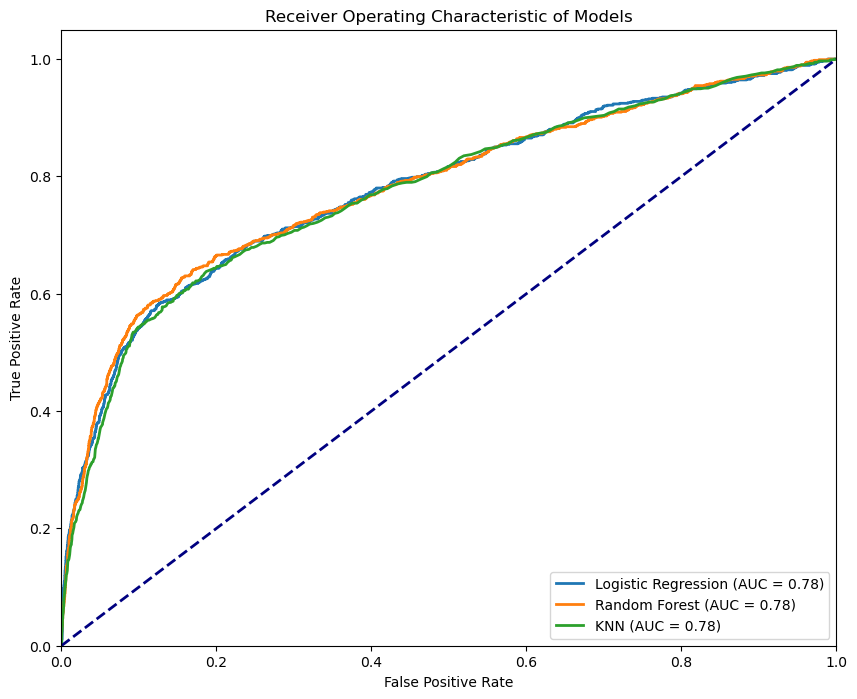

This figure shows the Receiver Operator Curves for the three classification models. More area under the curve indicates that the model does better at classification. The blue line represents random chance. Based on area under the curve, the Random Forest model has a slight edge over the other two models.  

Screenshot included to avoid re-running code.

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

models = [lr_best_model, rf_best_model, knn_best_model]
names = ['Logistic Regression', 'Random Forest', 'KNN']

# For each model, display the classification report and confusion matrix:
for model, name in zip(models, names):
    # Set the current model in the pipeline
    pipe.set_params(classifier=model)
    
    # Fit the model on training set 
    pipe.fit(X1_train_holdout, y1_train_holdout)
    
    # Get the probability scores from the fitted model
    y_pred = pipe.predict(X1_test_holdout)
    
    # Print the classification report
    print(f"{name} Classification Report:\n\n {classification_report(y1_test_holdout, y_pred)}")
   
    # Print the confusion matrix
    print(f"{name} Confusion Matrix:\n\n {confusion_matrix(y1_test_holdout, y_pred)}") 

Logistic Regression Classification Report:

               precision    recall  f1-score   support

          no       0.94      0.85      0.89      7310
         yes       0.33      0.59      0.42       928

    accuracy                           0.82      8238
   macro avg       0.64      0.72      0.66      8238
weighted avg       0.87      0.82      0.84      8238

Logistic Regression Confusion Matrix:

 [[6179 1131]
 [ 376  552]]
Random Forest Classification Report:

               precision    recall  f1-score   support

          no       0.92      0.96      0.94      7310
         yes       0.54      0.35      0.43       928

    accuracy                           0.89      8238
   macro avg       0.73      0.66      0.68      8238
weighted avg       0.88      0.89      0.88      8238

Random Forest Confusion Matrix:

 [[7025  285]
 [ 599  329]]
KNN Classification Report:

               precision    recall  f1-score   support

          no       0.94      0.89      0.91      7

**Results:** When evaluated on the holdout set, the models all have a very similar ROC-AUC. The Random Forest model has a slight edge based on AUC, but there are more subtle differences when looking at the confusion matrices. The Random Forest model has the most balance precision and recall for the 'yes' class, and the highest overall accuracy. It also does the best job of classifying the 'no' class. The Logistic Regression model has the highest recall for the 'yes' class, but the lowest precision. More research would be required, but one could argue that the model would be most useful if it were used to identify the most likely customers to subscribe to a term deposit. In that case, we would want to use the model with the highest recall for that class, which is the Logistic Regression model. However, the Random Forest model is the best overall classifier. 

All of the models are more useful for identifying customers who will not subscribe to a term deposit, and could be used to exclude such customers from the marketing campaign.

### Task Two: Regression

To evaluate the models we will test it on the holdout sets and visualize the results below.

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score

models = [lasso_best_model, xt_best_model, rfr_best_model]
names = ['Lasso Regression', 'Extra Trees Regresion', 'Random Forest Regression']
maes = []
r2s = []


plt.figure(figsize=(10, 8))

for model, name in zip(models, names):
    # Set the current model in the pipeline
    pipe.set_params(classifier=model)

#Fit the model on training set
    pipe.fit(X2_train_holdout, y2_train_holdout)

#Get the probability scores from the fitted model
    y_pred = pipe.predict(X2_test_holdout)

    #calculating and adding the metrics to the respected arrays
    maes.append(mean_absolute_error(y2_test_holdout, y_pred))
    r2s.append(r2_score(y2_test_holdout, y_pred))




<Figure size 1000x800 with 0 Axes>

Text(0.5, 1.0, 'R-Squared')

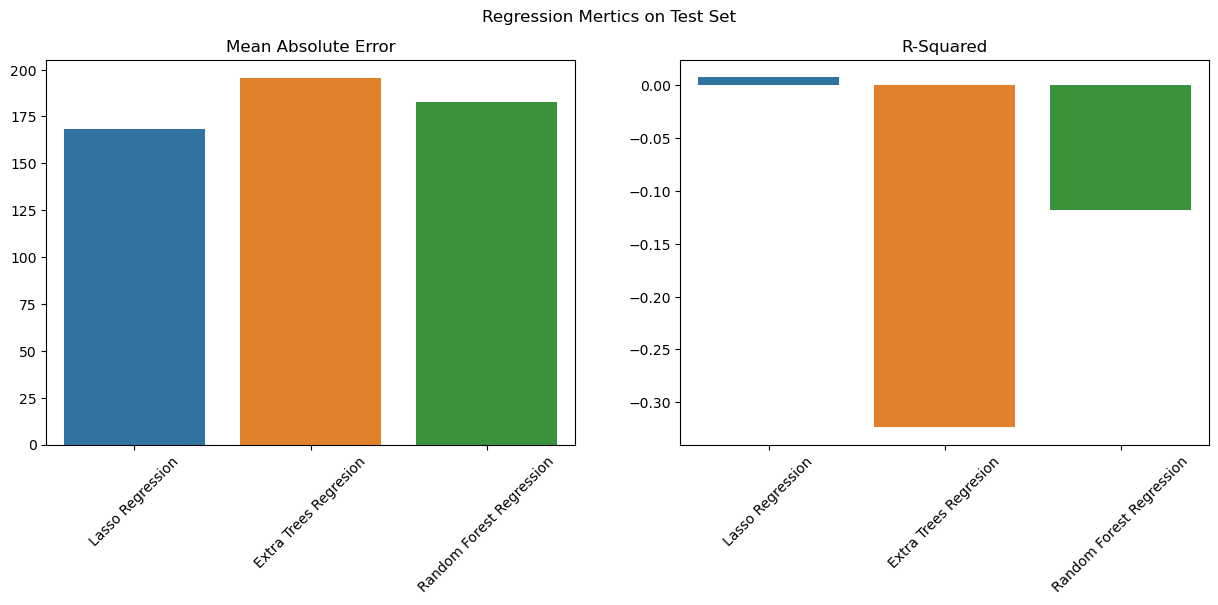

In [78]:

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Regression Mertics on Test Set')

#MAE
sns.barplot(ax=axes[0], x = names, y=maes)
#R2
sns.barplot(ax=axes[1], x = names, y=r2s)

axes[0].set_xticklabels(names, rotation=45)
axes[1].set_xticklabels(names, rotation=45)

axes[0].set_title("Mean Absolute Error")
axes[1].set_title("R-Squared")

**Results:** Above, Looking at the final metrics on the holdout set from the three models (Lasso, Extra Trees, and Random Forest Regressor). It was found that all the models fall short of predicting the test set well which they have large amount of errors and low r2 values. Of the models, lasso regression behaves the best with a non-negative r2 value but it is near 0 and has large amount of error. Overall the models does not predict the test case well. 

## Modeling and Evaluation 5

### Task One: Classification

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison

# Combine the scores into a single list and prepare a corresponding list indicating the model for each score
all_scores = lr_auc_scores + rf_auc_scores + knn_auc_scores
models = (['Logistic Regression'] * len(lr_auc_scores)) + (['Random Forest'] * len(rf_auc_scores)) + (['KNN'] * len(knn_auc_scores))

# Perform the ANOVA
anova = ols('values ~ group', data={'values': all_scores, 'group': models}).fit()
anova_table = sm.stats.anova_lm(anova, typ=2)
print(anova_table)

# Conduct post-hoc test if needed
if anova_table['PR(>F)'][0] < 0.5: # Change from 0.05 to do it anyway
    mc = MultiComparison(all_scores, models)
    mc_results = mc.tukeyhsd()
    print(mc_results)


Based on an ANOVA test of the AUC scores for the three classification models on the cross validation folds of the training set, there is not a significant difference in the performance of the models (p = 0.29). The Tukey's honest significant difference test for multiple comparisons agrees that we cannot conclude that the ROC-AUC is different.

Based on these findings, the model should be chosen by the most favorable other characteristics, such as recall of the 'yes' class, or ability to reject customers from the marketing campaign. 

### Task Two: Regression

In [112]:

from scipy import stats
import numpy as np

means = np.array([rfr_grid_search.cv_results_['mean_train_neg_mean_absolute_error'], lr_grid.cv_results_['mean_train_neg_mean_absolute_error'][0], xt_grid_search.cv_results_['mean_train_neg_mean_absolute_error']]) 
std_devs = np.array([rfr_grid_search.cv_results_['std_train_neg_mean_absolute_error'], lr_grid.cv_results_['std_train_neg_mean_absolute_error'][0], xt_grid_search.cv_results_['std_train_neg_mean_absolute_error']])  # e.g., np.array([0.1, 0.2, 0.3])
sample_sizes = np.array([5, 5, 5])  

#Overall mean
overall_mean = np.average(means, weights=sample_sizes)

#Between-group variability (Sum of Squares Between)
SSB = np.sum(sample_sizes * (means - overall_mean) ** 2)

#Within-group variability (Sum of Squares Within)
SSW = np.sum((sample_sizes - 1) * std_devs ** 2)

#Degrees of freedom
df_between = len(means) - 1
df_within = np.sum(sample_sizes - 1)

#Mean squares
MSB = SSB / df_between
MSW = SSW / df_within

#F-statistic
F = MSB / MSW

#P-value
p_value = 1 - stats.f.cdf(F, df_between, df_within)

#Output
print(f"F-statistic: {F}\nP-value: {p_value}")


F-statistic: [962144.17288668]
P-value: [1.11022302e-16]


C:\Users\Willj\AppData\Local\Temp\ipykernel_3788\3869759002.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  means = np.array([rfr_grid_search.cv_results_['mean_train_neg_mean_absolute_error'], lr_grid.cv_results_['mean_train_neg_mean_absolute_error'][0], xt_grid_search.cv_results_['mean_train_neg_mean_absolute_error']])
C:\Users\Willj\AppData\Local\Temp\ipykernel_3788\3869759002.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  std_devs = np.array([rfr_grid_search.cv_results_['std_train_neg_mean_absolute_error'], lr_grid.cv_results_['std_train_

From the ANOVA test the lasso mean MAE significantly differs from the other regresion model mean MAE (pvalue <0.001).

Lasso Regression: Good at generalizing performance, good at handling datasets where the number of variables are much larger than the number of observations, no need for feature selection since features with low predictive outcomes shrink to zero.

Random Forrest: Effective learning and better generalization of performance, can handle moderately large datasets, and less prone to overfit than decision trees.  

Extra Trees: Reduces the changces of overfitting, can be faster to train in some cases, and using the prediciton of multiple trees, can yield a more robust and accurate model.

## Modeling and Evaluation 6

### Task One: Classification

The feature loadings of the first principal component in Principal Component Analysis are shown on the figure below. They are plotted as absolute values, so they can be regarded as feature importance. The scale is logarithmic, so the difference in feature importance is much larger than it appears. We can see that 'Duration' is by far the most important feature, followed by 'Employment Number (Portugal)' and 'Campaign'. The economic features are all fairly highly ranked, which suggests they are an important predictor of subscription to a term deposit.

Based on these findings and discounting the duration for the reasons discussed above, we would hypothesize that economic features are the most important factors for whether customers subscribe to a term deposit. We would recommend that marketing campaigns be timed to coincide with these factors. Other important factors are the number of contacts during the campaign and the number of days since the last contact. These factors could be used to determine when to stop contacting a customer. Lastly, age is an important factor. As we have seen in the EDA, subscribers tend to be older. This may have to do with appetite for financial risk in the later stages of life and could be used to target marketing campaigns to older customers.

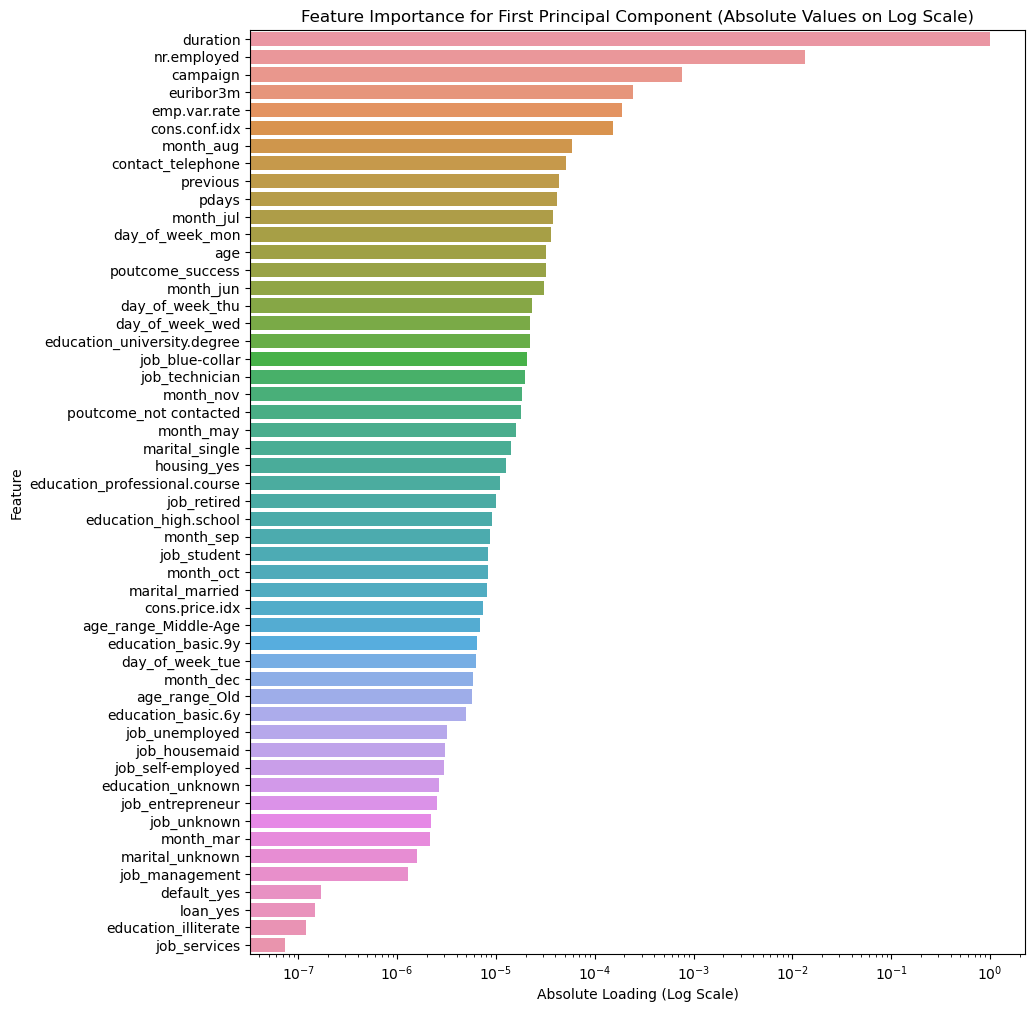

### Task Two: Regression

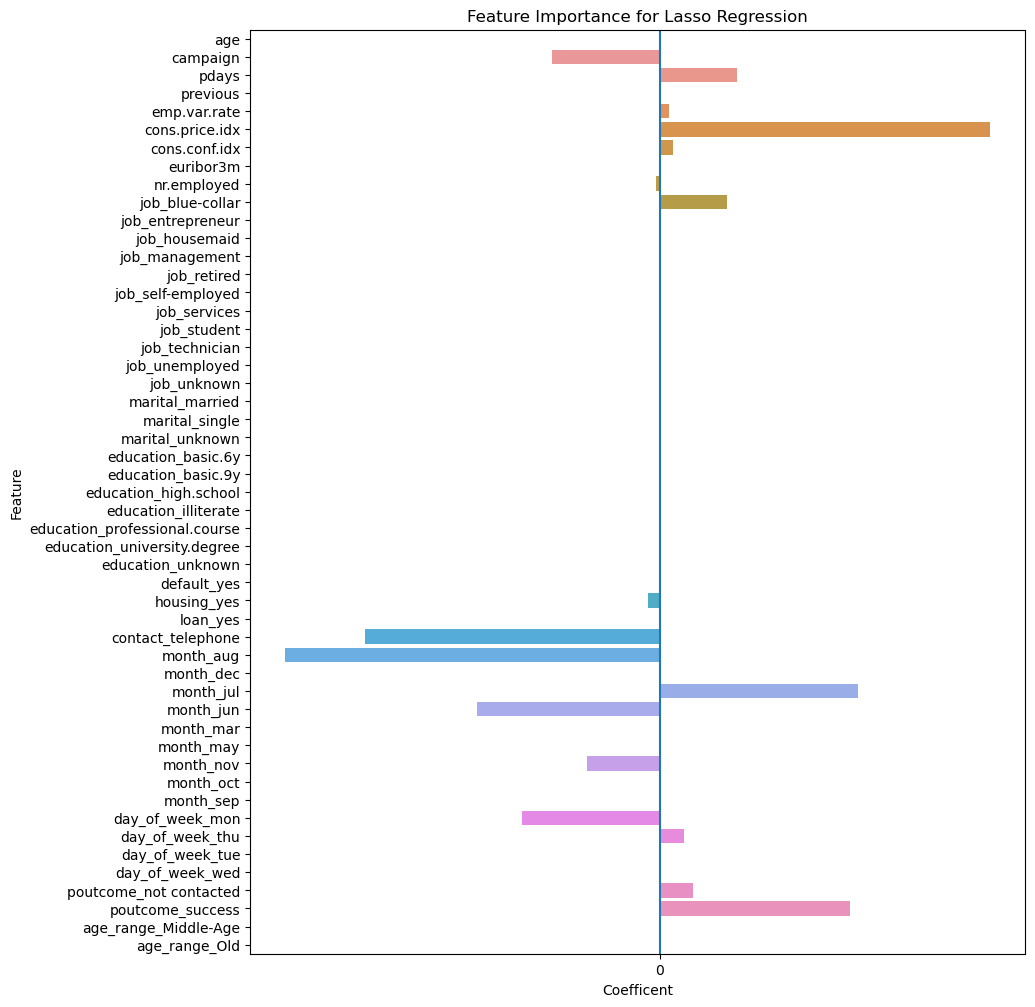

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
#fit the model
reg.fit(X2_train_holdout, y2_train_holdout)
#get feature names
temp = df2.copy()
temp = temp.drop('duration', axis=1)
#plot
plt.figure(figsize=(10,12))  # Increase the height
ax = sns.barplot(y=temp.columns, x=reg.coef_)
plt.title('Feature Importance for Lasso Regression')
plt.xlabel('Coefficent')
plt.axvline('0',linestyle='-')
plt.ylabel('Feature')
plt.show()


In the plot the most important features tend to be the economic features as well as the summer months, telephone contact, and if the day was monday. 

## Deployment

How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? 

### Task One: Classification

We originally sought to predict whether a customer would subscribe to a term deposit. Despite trying a variety of classification models and many combinations of parameters, we didn't find a model that excels at this. We did, however find a model that is quite good at identifying customers who will not subscribe to a term deposit. From a business standpoint, this could be very useful to identify which customers shouldn't be contacted for a marketing campaign. Our best classification model can identify these customers with greater than 0.9 precision and recall. This would be valuable to a marketing department because it would allow them to focus their efforts on customers who have a higher chance of subscribing to a term deposit, and save time and expense by not contacting customers who are unlikely to subscribe. More data wouldn't necessarily improve the model. Once the bank starts excluding customers from the marketing campaign, the model would run into algorithm effects and could lose it's ability to rule out customers with high precision. On the other hand, based on the importance of economic factors, it would make sense to update the model as those change.

### Task Two: Regression

We originally attempted to predict the duration of phone calls. Despite experimenting with various regression models and different parameter combinations, we were unable to find a model that performs well for this task. The regression models produced poor metrics on the test sets, rendering them unsuitable for any potential stakeholders.

If, by some chance, these models were to be deployed, it would be crucial to first assess the specific operational needs. For instance, determining whether the model should be run periodically, such as once a month, or on an ongoing basis. Subsequently, the models would need to be integrated into a fully operational pipeline or run periodically as a script.

To facilitate this process, the data should be prepared and structured within an ETL (Extract, Transform, Load) pipeline. This pipeline would enable data preprocessing and feature engineering before fitting it to the model for predictions. Given the long-term usage requirement, it may also be worth exploring the potential application of long short-term memory methods used in deep learning for improved predictive performance.

## Exceptional Work

We believe that the use of pipelines and grid search to tune the hyperparameters of the models is exceptional work. It also makes the code more readable and prevents data leakage.

## References

@article{Moro2014ADA,
  title={A data-driven approach to predict the success of bank telemarketing},
  author={S{\'e}rgio Moro and P. Cortez and Paulo Rita},
  journal={Decis. Support Syst.},
  year={2014},
  volume={62},
  pages={22-31},
  url={https://api.semanticscholar.org/CorpusID:14181100}
}

